<a href="https://colab.research.google.com/github/SammyBrimberry/GoogleBigQuery_attritionClassification/blob/main/gbq_attrition_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# account authentication
from google.colab import auth
auth.authenticate_user()
print('Authenticated') # check

Authenticated


In [3]:

# import biqguery, this is where our csv is living
from google.cloud import bigquery

# view settings
%load_ext google.colab.data_table

In [4]:
# store project_id into object
project_id = 'civil-hope-323521'

In [5]:
# init gbq client for specific cloud project
client = bigquery.Client(project=project_id)

In [6]:
# query our entire data living in google cloud
df = client.query('''
select * 
from `civil-hope-323521.attrition_dataset_1.IBM_attrition_2021` # project_id.database.table
''').to_dataframe()

df.head() # print out first 5 rows

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,48,False,Travel_Rarely,530,Sales,29,1,Medical,1,473,1,Female,91,3,3,Manager,3,Married,12504,23978,3,True,False,21,4,2,80,1,15,3,1,0,0,0,0
1,45,False,Travel_Frequently,364,Research & Development,25,3,Medical,1,1306,2,Female,83,3,5,Manager,2,Single,18061,13035,3,True,False,22,4,3,80,0,22,4,3,0,0,0,0
2,41,False,Travel_Rarely,896,Sales,6,3,Life Sciences,1,298,4,Female,75,3,3,Manager,4,Single,13591,14674,3,True,True,18,3,3,80,0,16,3,3,1,0,0,0
3,57,False,Travel_Rarely,210,Sales,29,3,Marketing,1,568,1,Male,56,2,4,Manager,4,Divorced,14118,22102,3,True,False,12,3,3,80,1,32,3,2,1,0,0,0
4,42,False,Travel_Rarely,265,Sales,5,2,Marketing,1,1029,4,Male,90,3,5,Manager,3,Married,18303,7770,6,True,False,13,3,2,80,0,21,3,4,1,0,0,0


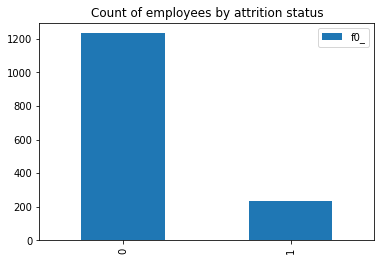

In [34]:
# count number of attrition
# imbalanced classification problem
df = client.query('''
select count(attrition), attrition
from `civil-hope-323521.attrition_dataset_1.IBM_attrition_2021`
group by attrition
''').to_dataframe()
# plot output
df.plot(kind='bar',title = "Count of employees by attrition status")

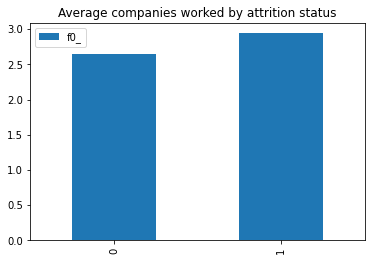

In [7]:
# roles by attrition status
df = client.query('''
select avg(NumCompaniesWorked)
from `civil-hope-323521.attrition_dataset_1.IBM_attrition_2021`
group by attrition
''').to_dataframe()

# plot data
df.plot(kind='bar',title = "Average companies worked by attrition status")

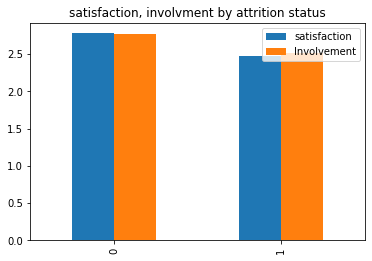

In [18]:
# job satisfaction rating by attrition status
df = client.query('''
select avg(JobSatisfaction) as satisfaction, avg(JobInvolvement) as Involvement, attrition
from `civil-hope-323521.attrition_dataset_1.IBM_attrition_2021`
group by attrition
''').to_dataframe()
# plot 
df.plot(kind='bar',title = "satisfaction, involvment by attrition status")

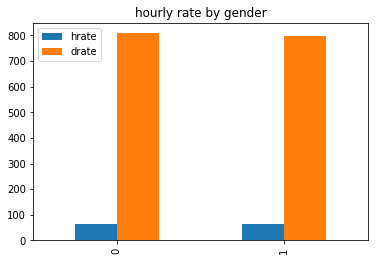

In [24]:
# avg hourly rate, monthly rate and monlthy income for female employees 
df = client.query('''
select avg(hourlyrate) as hrate, avg(dailyrate) as drate
from `civil-hope-323521.attrition_dataset_1.IBM_attrition_2021`
group by gender 
''').to_dataframe()

# plot data
df.plot(kind='bar',title = "hourly rate by gender")

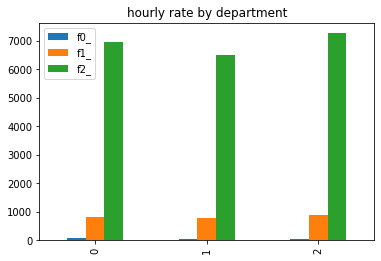

In [31]:
# avg hourly rate, monthly rate and monlthy income for female employees 
df = client.query('''
select --avg(hourlyrate), avg(dailyrate), avg(monthlyincome)
from `civil-hope-323521.attrition_dataset_1.IBM_attrition_2021`
where gender = 'Female'
group by department 
''').to_dataframe()

# plot data
df.plot(kind='bar',title = "hourly rate by department")


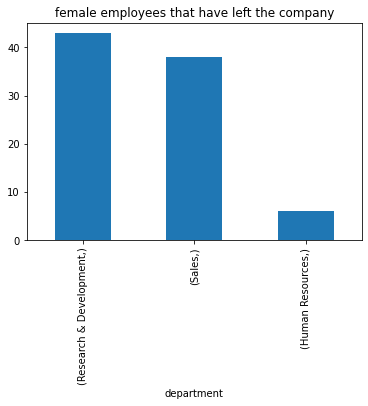

In [19]:
# count department where attrition is true for female employees
df = client.query('''
select department
from `civil-hope-323521.attrition_dataset_1.IBM_attrition_2021`
where attrition=True and gender = "Female"''').to_dataframe()

# plot
df.value_counts().plot(kind='bar',title='female employees that have left the company')

In [9]:
# compare avg. salary hike split by attrition status
# 0 is no attrition
# 1 is attrition
df = client.query('''
select avg(PercentSalaryHike)
from `civil-hope-323521.attrition_dataset_1.IBM_attrition_2021`
group by attrition
''').to_dataframe()

df.head()

,f0_
0,15.231144
1,15.097046


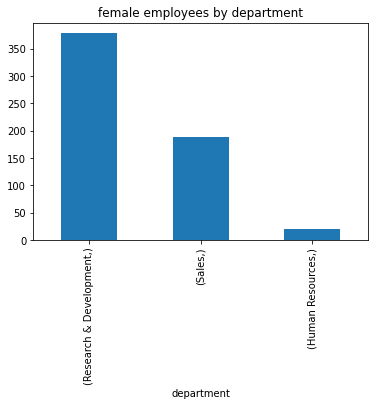

In [63]:
# count of female identifying employees by department
df = client.query('''
select department
from `civil-hope-323521.attrition_dataset_1.IBM_attrition_2021`
where gender = "Female"''').to_dataframe()

# plot the count of df in a bar chart
df.value_counts().plot(kind = 'bar',title='female employees by department')

'\nthere seems to be more males working at the company than female\ncompare y-axis\n'

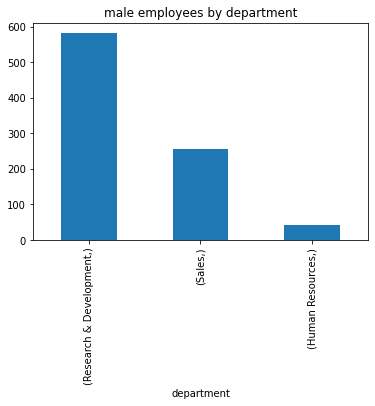

In [62]:
# count of male identifying employees by department
df = client.query('''
select department
from `civil-hope-323521.attrition_dataset_1.IBM_attrition_2021`
where gender = "Male"''').to_dataframe()
df.value_counts().plot(kind = 'bar', title='male employees by department')

'''
there seems to be more males working at the company than female
compare y-axis
'''

# Classification using simple logistic reggression

In [62]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix

from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

In [40]:
# query our entire data living in google cloud
df = client.query('''
select * 
from `civil-hope-323521.attrition_dataset_1.IBM_attrition_2021` # project_id.database.table
''').to_dataframe()

df.head() # print out first 5 rows

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,48,False,Travel_Rarely,530,Sales,29,1,Medical,1,473,1,Female,91,3,3,Manager,3,Married,12504,23978,3,True,False,21,4,2,80,1,15,3,1,0,0,0,0
1,45,False,Travel_Frequently,364,Research & Development,25,3,Medical,1,1306,2,Female,83,3,5,Manager,2,Single,18061,13035,3,True,False,22,4,3,80,0,22,4,3,0,0,0,0
2,41,False,Travel_Rarely,896,Sales,6,3,Life Sciences,1,298,4,Female,75,3,3,Manager,4,Single,13591,14674,3,True,True,18,3,3,80,0,16,3,3,1,0,0,0
3,57,False,Travel_Rarely,210,Sales,29,3,Marketing,1,568,1,Male,56,2,4,Manager,4,Divorced,14118,22102,3,True,False,12,3,3,80,1,32,3,2,1,0,0,0
4,42,False,Travel_Rarely,265,Sales,5,2,Marketing,1,1029,4,Male,90,3,5,Manager,3,Married,18303,7770,6,True,False,13,3,2,80,0,21,3,4,1,0,0,0


In [41]:
# define features
X = df.drop(columns='Attrition')
X = pd.get_dummies(X)
# set target
target = ['Attrition'] # we want to predict this value
y = df.loc[:, target].copy()

In [45]:
df = df.drop(columns=['EmployeeCount','EmployeeNumber'])

In [46]:
X.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129,0.102041,0.188435,0.709524,0.042857,0.653741,0.303401,0.018367,0.412245,0.108163,0.315646,0.055782,0.089796,0.400000,0.600000,0.089116,0.035374,0.176190,0.069388,0.098639,0.054422,0.198639,0.221769,0.056463,0.222449,0.457823,0.319728
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136,0.302805,0.391193,0.454137,0.202604,0.475939,0.459884,0.134321,0.492406,0.310692,0.464931,0.229579,0.285986,0.490065,0.490065,0.285008,0.184786,0.381112,0.254199,0.298279,0.226925,0.399112,0.415578,0.230891,0.416033,0.498387,0.466530
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0

In [51]:
y['Attrition'].value_counts() # same as SQL count above

False    1233
True      237
Name: Attrition, dtype: int64

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=41)

In [53]:
model = LogisticRegression(solver='lbfgs',random_state=42)
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
target_predictions = model.predict(X_test)
balanced_accuracy_score(y_test, target_predictions)

0.5

In [55]:
confusion_matrix(y_test, target_predictions)

array([[298,   0],
       [ 70,   0]])

In [56]:
# model has a hard time predicting cases where attrition is true
print(classification_report_imbalanced(y_test, target_predictions))

                   pre       rec       spe        f1       geo       iba       sup

      False       0.81      1.00      0.00      0.89      0.00      0.00       298
       True       0.00      0.00      1.00      0.00      0.00      0.00        70

avg / total       0.66      0.81      0.19      0.72      0.00      0.00       368



# classification using naive random oversampling

In [57]:

# create a resampling object
ros = RandomOverSampler(random_state = 42)

# fitting the resampled training data
X_NRO_resample, y_NRO_resample = ros.fit_resample(X_train, y_train)

# train the model with the resampled data
model.fit(X_NRO_resample, y_NRO_resample)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
# make y value predictions
naive_random_oversampling_predictions = model.predict(X_test)

# balanced accuracy score
balanced_accuracy_score(y_test, naive_random_oversampling_predictions)

0.6540747842761265

In [59]:
# confusion matrix
confusion_matrix(y_test, naive_random_oversampling_predictions)

array([[194, 104],
       [ 24,  46]])

In [60]:
# imbalanced learn classification report
print(classification_report_imbalanced(y_test, naive_random_oversampling_predictions))

                   pre       rec       spe        f1       geo       iba       sup

      False       0.89      0.65      0.66      0.75      0.65      0.43       298
       True       0.31      0.66      0.65      0.42      0.65      0.43        70

avg / total       0.78      0.65      0.66      0.69      0.65      0.43       368



# smote oversampling

In [63]:
# Resample the training data with SMOTE
X_SMOTE_resampled, y_SMOTE_resampled = SMOTE(random_state=42, sampling_strategy=1.0).fit_resample(X_train, y_train)

# View the count of target classes with Counter
Counter(y_SMOTE_resampled)

Counter({False: 935, True: 935})

In [64]:
# Train the Logistic Regression model using the SMOTE resampled data
model.fit(X_SMOTE_resampled, y_SMOTE_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
# make y value predictions
SMOTE_oversampling_predictions = model.predict(X_test)

# balanced accuracy score
balanced_accuracy_score(y_test, SMOTE_oversampling_predictions)

0.6448705656759348

In [66]:
# confusion matrix
confusion_matrix(y_test, SMOTE_oversampling_predictions)

array([[180, 118],
       [ 22,  48]])

In [67]:
# imbalanced learn classification report
print(classification_report_imbalanced(y_test, SMOTE_oversampling_predictions))

                   pre       rec       spe        f1       geo       iba       sup

      False       0.89      0.60      0.69      0.72      0.64      0.41       298
       True       0.29      0.69      0.60      0.41      0.64      0.42        70

avg / total       0.78      0.62      0.67      0.66      0.64      0.41       368



# Undersampling with cluster centroids

In [68]:
# resample the training data using cluster centroids
ClusterCentroids = ClusterCentroids(random_state = 42)
X_cc_resampled, y_cc_resampled = ClusterCentroids.fit_resample(X_train, y_train)

In [69]:
# train the logistic regression model with resampled data
model.fit(X_cc_resampled, y_cc_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [70]:
# make y value predictions
ClusterCentroidd_predictions = model.predict(X_test)

# balanced accuracy score
balanced_accuracy_score(y_test, ClusterCentroidd_predictions)

0.6692713326941515

In [71]:
# imbalanced classification report
print(classification_report_imbalanced(y_test, ClusterCentroidd_predictions))

                   pre       rec       spe        f1       geo       iba       sup

      False       0.91      0.57      0.77      0.70      0.66      0.43       298
       True       0.30      0.77      0.57      0.43      0.66      0.45        70

avg / total       0.80      0.61      0.73      0.65      0.66      0.43       368

